In [42]:
from transformers import AutoImageProcessor, TimesformerForVideoClassification
import numpy as np
import torch

video = np.random.rand(4,8, 3, 224, 224)

processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k600")
model = TimesformerForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k600")

inputs = processor(images=video, return_tensors="pt")

with torch.no_grad():
  outputs = model.timesformer(**inputs).last_hidden_state
  feature = outputs[:,1:].reshape(-1, 8, 14, 14, 768)
  

print(feature.shape)

ValueError: Unsupported number of image dimensions: 5

In [ ]:
from openai import OpenAI
client = OpenAI()

moderation = client.moderations.create(input='David de Rothschild is an environmental entrepreneur and adventurer from the Rothschild banking family. He is best known for his work in environmental advocacy and awareness. David has led various expeditions to draw attention to environmental issues, such as his 2010 journey across the Pacific Ocean on the "Plastiki"—a boat made from recycled plastic bottles—to highlight the problem of plastic pollution. Beyond his expeditions, he is involved in promoting sustainability and environmental preservation through various projects and speaking engagements. David’s work combines adventure with a strong message of conservation and responsible interaction with the natural world.', model="text-moderation-latest")
print(any(dict(moderation.results[0].categories).values()))

False


: 

In [ ]:
from transformers import BeitForSemanticSegmentation, BeitConfig
config = BeitConfig.from_pretrained("microsoft/beit-base-finetuned-ade-640-640")
config.num_channels = 9
config.image_size = 640
backbone = BeitForSemanticSegmentation.from_pretrained("microsoft/beit-base-finetuned-ade-640-640", config=config, ignore_mismatched_sizes=True)
backbone.decode_head.classifier = torch.nn.Identity()


/home/wg25r/.local/lib/python3.10/site-packages/transformers/models/beit/configuration_beit.py:197: FutureWarning: The `segmentation_indices` argument is deprecated and will be removed in a future version, use `out_indices` instead.
  warnings.warn(
Some weights of BeitForSemanticSegmentation were not initialized from the model checkpoint at microsoft/beit-base-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- beit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 9, 16, 16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
import torch 
backbone(torch.randn(1, 9, 640, 640)).logits.shape

torch.Size([1, 768, 160, 160])

In [28]:
from transformers import SegformerForSemanticSegmentation
backbone = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
backbone

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-cityscapes-1024-1024 and are newly initialized: ['segformer.encoder.test.bias', 'segformer.encoder.test.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [2]:
import torchvision
swin_t = torchvision.models.swin_t()

In [16]:
import torch
swin_t.features[7][0](torch.randn(1, 224, 224, 768)).shape

torch.Size([1, 224, 224, 768])

In [ ]:
import os


shadow_copyMachine_in002901.jpg


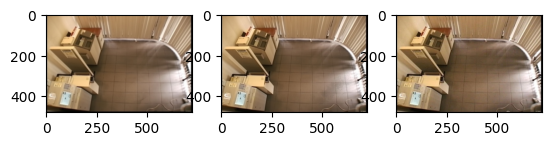

In [50]:
import pylab
files = [i for i in sorted(os.listdir("/mnt/fastdata/CDNet/sub_long")) if i.startswith("shadow_copyMachine")]
idx = -500
print(files[idx])
pylab.subplot(1,3,1)
pylab.imshow(pylab.imread("/mnt/fastdata/CDNet/sub_long/"+files[idx]))
pylab.subplot(1,3,2)
pylab.imshow(pylab.imread("/mnt/fastdata/CDNet/long/"+files[idx]))
pylab.subplot(1,3,3)
pylab.imshow(pylab.imread("/mnt/fastdata/CDNet/sub_in/"+files[idx]))


In [2]:
import torch
import numpy as np
pred = np.random.rand(4, 256, 640, 640)
target = np.random.rand(4, 256, 640, 640) > 0.5
ROI = np.random.rand(4, 640, 640) > 0.9

In [ ]:

def matching_loss(pred, target, ROI):
    pred = torch.nn.functional.avg_pool2d(pred, 4)
    target = torch.nn.functional.avg_pool2d(target * 1.0, 4)
    ROI = torch.nn.functional.max_pool2d(ROI * 1.0, 4)
    
    pred = pred.permute(0, 2, 3, 1)
    target = target.permute(0, 2, 3, 1)
    assert pred.shape[:-1] == target.shape[:-1] == ROI.shape, f"pred shape: {pred.shape}, target shape: {target.shape}, ROI shape: {ROI.shape}"
    assert len(pred.shape) == 4
    assert pred.shape[1:] == (160, 160, 256)
    
    for sample in range(pred.shape[0]):
        pred_ = pred[sample][ROI[sample]>0.9] 
        target_ = target[sample][ROI[sample]>0.9]
        assert pred_.shape[1:]==(256,), f"pred shape: {pred_.shape}"
        matching_volume = torch.einsum("ae,be->ab", pred_, pred_)
        axis1 = target_.unsqueeze(0).repeat(pred_.shape[0], 1, 1)
        axis2 = axis1.permute(1, 0, 2)
        print(axis1.shape)
    
    matching_volume = torch.sigmoid(matching_volume)  
    
matching_loss(torch.tensor(pred).cuda(), torch.tensor(target).cuda(), torch.tensor(ROI).cuda())

OutOfMemoryError: CUDA out of memory. Tried to allocate 415.34 GiB. GPU 0 has a total capacity of 47.53 GiB of which 3.45 GiB is free. Process 1418160 has 590.00 MiB memory in use. Process 3723448 has 590.00 MiB memory in use. Process 3730041 has 33.64 GiB memory in use. Including non-PyTorch memory, this process has 8.95 GiB memory in use. Of the allocated memory 7.12 GiB is allocated by PyTorch, and 1.52 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)